In [44]:
#pip install ipywidgets rio-tiler supabase mercantile matplotlib

In [1]:
import os
import json
import requests
import ipywidgets as widgets
from supabase import create_client, Client
from rio_tiler.io import COGReader
import pyproj
import dotenv

In [12]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./deep-learning-earth-d9ea763f10c9.json"
os.environ["GDAL_HTTP_COOKIEFILE"] = "/vsimem/cookies.txt"
os.environ["GDAL_HTTP_COOKIEJAR"] = "/vsimem/cookies.txt"
os.environ["CPL_VSIL_CURL_ALLOWED_EXTENSIONS"] = ".tif"
os.environ["GDAL_DISABLE_READDIR_ON_OPEN"] = "EMPTY_DIR"
os.environ["VSI_CACHE"] = "TRUE"
os.environ["VSI_CACHE_SIZE"] = "1000000"

In [13]:
from dotenv import load_dotenv

load_dotenv()

# Set your Supabase URL and Key
SUPABASE_URL = os.getenv("SUPABASE_URL")
SUPABASE_KEY = os.getenv("SUPABASE_KEY")

# Create a Supabase client
supabase: Client = create_client(SUPABASE_URL, SUPABASE_KEY)

In [14]:
def get_cogs_from_supabase():
    """Fetch the list of COGs from Supabase."""
    response = supabase.table("sentinel2_cogs").select("*").execute()
    if response.data:
        return response.data
    else:
        return []

# Fetch the COGs
cogs = get_cogs_from_supabase()
cog_names = [cog['identifier'] for cog in cogs if cog['status'] == 'ready']  # Assuming 'identifier' is the field for COG names

# Cell 4: Offer a list with ipywidgets
cog_selector = widgets.Dropdown(
    options=cog_names,
    description='Select COG:',
    disabled=False,
)

display(cog_selector)

Dropdown(description='Select COG:', options=('b9f42c7b-13ab-484d-ab65-a994ad79441c',), value='b9f42c7b-13ab-48…

In [15]:
print(cogs)

[{'id': 30, 'created_at': '2025-01-30T17:31:10.739017+00:00', 'identifier': 'b9f42c7b-13ab-484d-ab65-a994ad79441c', 'status': 'ready', 'bucket': 'dl4eo-sentinel2-cogs', 'path': 'cogs/b9f42c7b-13ab-484d-ab65-a994ad79441c_rgb.tif'}]


In [36]:
def get_cog_extent(cog_identifier):
    """Get the extent of the selected COG."""
    selected_cog = next((cog for cog in cogs if cog['identifier'] == cog_identifier), None)
    if selected_cog:
        # This is the Google Storage bucket and path
        url = "gs://" + selected_cog['bucket'] + "/" + selected_cog['path']
        with COGReader(url) as cog:
            return cog.bounds, cog.crs
    return None

def on_cog_change(change):
    """Callback function to display the extent when a COG is selected."""
    extent = get_cog_extent(change['new'])
    if extent:
        print(f"Extent of {change['new']}: {extent}")

cog_selector.observe(on_cog_change, names='value')

In [60]:
from pyproj import Transformer
import random
# Get COG extent in image projection
bounds_src, crs_src = get_cog_extent(cog_selector.value)
print(f"Bounds in {crs_src}: {bounds_src}")

# Convert to EPSG:4326
transformer = Transformer.from_crs(crs_src, "EPSG:4326", always_xy=True)
bounds_epsg4326 = transformer.transform_bounds(*bounds_src)
print(f"Bounds in EPSG:4326: {bounds_epsg4326}")

# Select location at the center of the bounds
center_lat, center_lon = (bounds_epsg4326[1] + bounds_epsg4326[3]) / 2, (bounds_epsg4326[0] + bounds_epsg4326[2]) / 2

# Select a point at random within the bounds
center_lat, center_lon = random.uniform(bounds_epsg4326[1], bounds_epsg4326[3]), random.uniform(bounds_epsg4326[0], bounds_epsg4326[2])
print(f"Center of bounds: {center_lat}, {center_lon}")


Bounds in EPSG:32618: (300000.0, 3990240.0, 409800.0, 4100040.0)
Bounds in EPSG:4326: (-77.24837990394673, 36.036167697666194, -76.00145196296135, 37.04224724177572)
Center of bounds: 36.38588198256902, -76.55192299939243


In [68]:
import mercantile
methods = ["lanczos", "nearest", "average", "cubic"]

def get_tiles(cog_identifier, lat, lon, z=14):
    """Get tiles for the selected COG at specified zoom levels."""
    selected_cog = next((cog for cog in cogs if cog['identifier'] == cog_identifier), None)
    if selected_cog:
        # Assuming the COG URL is stored in 'url' field
        cog_url = "gs://" + selected_cog['bucket'] + "/" + selected_cog['path']  # Adjust based on your actual field name
        with COGReader(cog_url) as cog:
            # compute the x, y, z of the tile in the image projection
            tile_x, tile_y, tile_z = mercantile.tile(lon, lat, z)
            tiles = []
            for method in methods:
                tile = cog.tile(tile_x, tile_y, tile_z, resampling_method=method) #, buffer=2.0)
                tiles.append(tile)
            return tiles

In [72]:
tiles = get_tiles(cog_selector.value, center_lat, center_lon, 14)
print(type(tiles[0].data))

# Apply Gaussian blur directly on ndarray in order CWH
def apply_gaussian_blur(tile_data, radius=1):
    # Convert CWH to HWC
    image_array = tile_data.transpose(1, 2, 0)
    # Create a PIL Image
    pil_image = Image.fromarray(image_array)
    # Apply Gaussian blur
    pil_image = pil_image.filter(ImageFilter.GaussianBlur(radius=radius))
    # Convert back to ndarray and transpose to CWH
    blurred_array = np.array(pil_image).transpose(2, 0, 1).astype(np.uint8)
    return blurred_array

# Apply Gaussian blur to each tile
blurred_tiles = [apply_gaussian_blur(tile.data) for tile in tiles]

# Print the type of the blurred tiles
print(type(blurred_tiles[0]))



<class 'numpy.ndarray'>


Method: lanczos


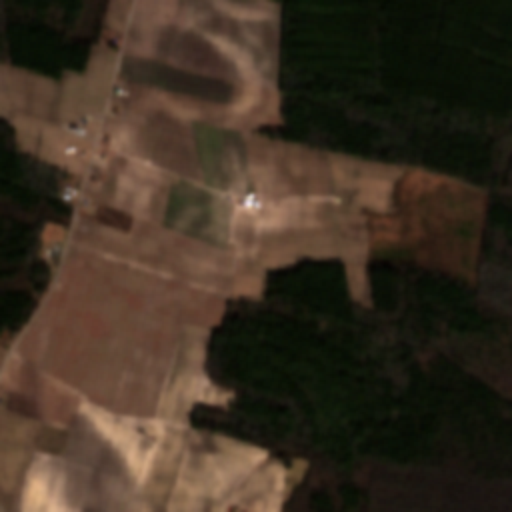

Method: nearest


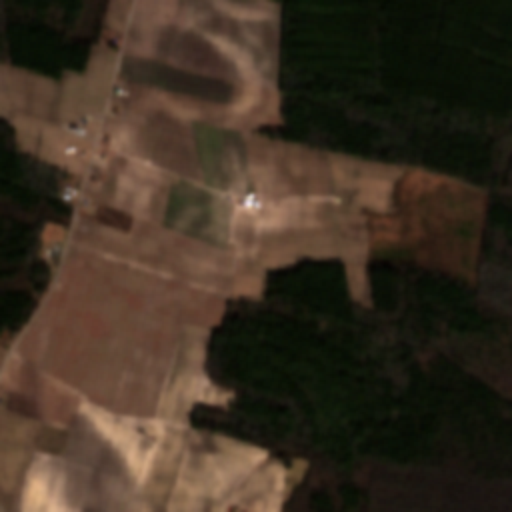

Method: average


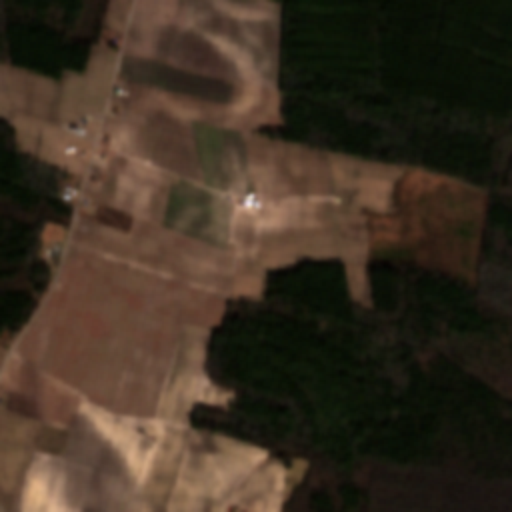

Method: cubic


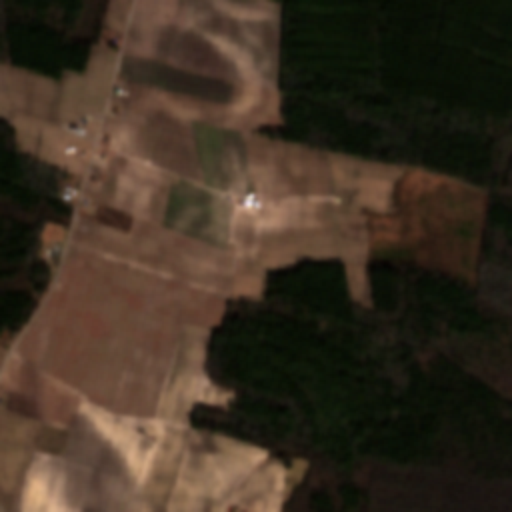

In [69]:
# Display the tile
import numpy as np
from PIL import Image, ImageFilter
from IPython.display import display

tiles = get_tiles(cog_selector.value, center_lat, center_lon, 14)

# Convert ImageData to a NumPy array CWH to HWC
image_arrays = [tile.data.transpose(1, 2, 0) for tile in tiles]

# Create a PIL Image
pil_images = [Image.fromarray(image_array) for image_array in image_arrays]

# apply a gaussian blur to the image
pil_images = [pil_image.filter(ImageFilter.GaussianBlur(radius=1)) for pil_image in pil_images]

# Display the image
for i, pil_image in enumerate(pil_images):
    print(f"Method: {methods[i]}")
    display(pil_image.resize((pil_image.width * 2, pil_image.height * 2)))

In [48]:
type(tile)

rio_tiler.models.ImageData